## Solving Poisson Equation Using Discontinuous Galerkin

This program solves the Poisson equation
$$- \Delta u(x, y) = f(x, y)$$
on the unit square with source $f$ given by
$$f(x, y) = -100e^{-50((x - 0.5)^2 + (y - 0.5)^2)}$$
and boundary conditions given by
\begin{align*}
    u(x, y)     & = u_0 & \mbox{on } x = 0 \mbox{ and } x = 1 \\
    \partial_\boldsymbol{n} u(x, y) & = g  & \mbox{ on } y = 0 \mbox{ and } y = 1 \\
\end{align*}    
where
\begin{align*}
    u_0 & = x + 0.25\sin(2\pi x)\\
    g & = (y - 0.5)^2
\end{align*}
using a symmetric internal penalty discontinuous Galerkin (SIP/DG) formulation.

In [1]:
from fenics import *
%matplotlib inline

Define the source term $f$, Dirichlet term $u_0$ and Neumann term $g$.

In [2]:
f = Expression('-100.0*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)', degree=2)
u0 = Expression('x[0] + 0.25*sin(2*pi*x[1])', degree=2)
g = Expression('(x[1] - 0.5)*(x[1] - 0.5)', degree=2)

We now create a mesh and define function space.

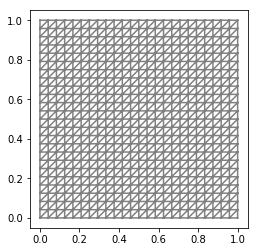

In [3]:
mesh = UnitSquareMesh(24, 24)
V = FunctionSpace(mesh, 'DG', 1)

plot(mesh)

Define both test and trial functions to be discontinuous.

In [4]:
u = TrialFunction(V)
v = TestFunction(V)

Define normal vector and mesh size. FEniCS supports '+' and '-' indices for element/cell size and functions.

In [5]:
n = FacetNormal(mesh)

h = CellSize(mesh)
h_avg = (h('+') + h('-'))/2

Mark all facets of mesh as boundaries.

In [6]:
boundaries = FacetFunction('size_t', mesh, 0)

In [7]:
parameters["ghost_mode"] = "shared_facet"

Define class marking Dirichlet boundary ($x = 0$ or $x = 1$).

In [8]:
class DirichletBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0]*(1 - x[0]), 0)

Define class marking Neumann boundary ($y = 0$ or $y = 1$).

In [9]:
class NeumanBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1]*(1 - x[1]), 0)

Mark facets of the mesh.

In [10]:
NeumanBoundary().mark(boundaries, 2)
DirichletBoundary().mark(boundaries, 1)

Define outer surface measure aware of Dirichlet and Neumann boundaries.

In [11]:
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

Define parameters.

In [12]:
alpha = 4.0
gamma = 8.0

Define variational problem. FEniCS supports `avg` and `jump` operators.

In [13]:
a = dot(grad(v), grad(u))*dx \
   - dot(avg(grad(v)), jump(u, n))*dS \
   - dot(jump(v, n), avg(grad(u)))*dS \
   + alpha/h_avg*dot(jump(v, n), jump(u, n))*dS \
   - dot(grad(v), u*n)*ds(1) \
   - dot(v*n, grad(u))*ds(1) \
   + (gamma/h)*v*u*ds(1)

L = v*f*dx - u0*dot(grad(v), n)*ds(1) + (gamma/h)*u0*v*ds(1) + g*v*ds(2)

Compute solution.

L2 norm of solution is: 0.5835469772085158


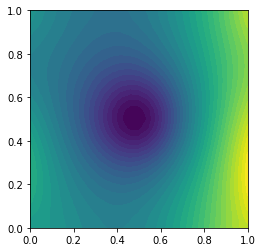

In [14]:
u = Function(V)
solve(a == L, u)

print("L2 norm of solution is: {!r}".format(norm(u, 'L2')))
plot(u)

Comparison with solution with Galerkin method:

L2 norm of solution is: 0.5826614582135226


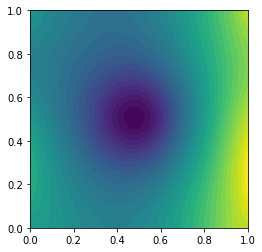

In [15]:
V = FunctionSpace(mesh, 'P', 1)

u = TrialFunction(V)
v = TestFunction(V)

# Define variational problem
ds = Measure('ds', domain=mesh)
a = dot(grad(u), grad(v))*dx
L = f*v*dx + g * v * ds

# Define Dirichlet boundary condition
def is_DirichletBoundary(x, on_boundary):
    return on_boundary and near(x[0]*(1 - x[0]), 0)

bc = DirichletBC(V, u0, is_DirichletBoundary)

# Solve the problem
u = Function(V)
solve(a == L, u, bc)

print("L2 norm of solution is: {!r}".format(norm(u, 'L2')))
plot(u)

Acknowledgements: This notebook was adapted from [FEniCS undocumented demo](https://github.com/FEniCS/dolfin/blob/master/demo/undocumented/dg-poisson/python/demo_dg-poisson.py).